In [75]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

from matplotlib import animation, gridspec

ccrs = cartopy.crs

print('packages check')

### INITIALISATION

vvel_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/VVELcomposite.nc'
sigma_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc'


labels = [r'Barotropic Streamfunction Anomaly $\Delta BSF$ [Sverdrup]', 
          r'Depth Streamfunction Anomaly $\Delta dMOC$ [Sverdrup]', 
          r'Density Streamfunction Anomaly $\Delta \sigma MOC$ [Sverdrup]']
cmap = cmo.balance

print('initialisation complete')

### COMPUTATION

vvel_ds = xr.open_dataset(vvel_file)#.isel(time=slice(0,3))
sigma_ds = xr.open_dataset(sigma_file)#.isel(time=slice(0,3))
dens_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.001.nc'
ds = xr.open_dataset(dens_file).isel(time=0)

print('composite nc files have been opened')

packages check
initialisation complete
composite nc files have been opened


# Compute composites

In [2]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
files = sorted(glob.glob(path + 'temp/*.nc'))
files[0][-11:]

'1001.001.nc'

In [3]:
ds = xr.open_dataset(dens_file).isel(time=0)

In [4]:
## stream functions
def BSF(ds, ds_parameters):
    bsf = []
    for time_idx in range(len(ds.time)):
        ds_time_step = ds.isel(time=time_idx)
        bsf_time_step = (ds_time_step.VVEL * ds_parameters.dz * ds_parameters.DXU).sum(dim='z_t').cumsum(dim='nlon')
        bsf.append(bsf_time_step)
    bsf_ds = xr.concat(bsf, dim='time')
    return bsf_ds*1e-12

def depth_MOC(ds, ds_parameters):
    dmoc = []
    for time_idx in range(len(ds.time)):
        ds_time_step = ds.isel(time=time_idx)
        dmoc_time_step = (ds_time_step.VVEL * ds_parameters.dz * ds_parameters.DXU).sum(dim='nlon').cumsum(dim='z_t')
        dmoc.append(dmoc_time_step)
    dmoc_ds = xr.concat(dmoc, dim='time')
    return dmoc_ds*1e-12

def density_MOC(ds_vvel, ds_sigma, ds_parameters):
    #sigma_level = [32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 
    #            35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.3, 36.4, 36.46, 
    #            36.54, 36.6, 36.65, 36.69, 36.73, 36.75, 36.78, 36.82, 36.84, 36.86, 36.88, 36.9, 
    #            36.92, 36.94, 36.96, 36.98, 37.,]
    sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
    min_lat = 250
    max_lat = 365
    smoc = []
    for time_idx in range(len(ds_vvel.time)):
        ds_vvel_time_step = ds_vvel.isel(time=time_idx)
        ds_sigma_time_step = ds_sigma.isel(time=time_idx)
        overturning = np.zeros([len(sigma_level), (max_lat - min_lat)])
        for j in range(min_lat, max_lat):
            sigma_transport = np.zeros(len(sigma_level))
            v_transport = (ds_vvel_time_step.VVEL.isel(nlat=j) * ds_parameters.dz.isel(nlat=j) * ds_parameters.DXU.isel(nlat=j)).values
            sigma_crossection = ds_sigma_time_step.SIGMA_2.isel(nlat=j).values
            for i in range(len(sigma_level) - 1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i + 1]))
                sigma_transport[i] = np.nansum(v_transport[ind])
            overturning[:, j - min_lat] = np.cumsum(sigma_transport)[::-1]
            overturning[:, j - min_lat] = overturning[:, j - min_lat][::-1]
        overturning_ds = xr.Dataset({'densMOC': (['sigma', 'nlat'], overturning)})
        overturning_ds['densMOC'] = overturning_ds.densMOC*1e-12
        overturning_ds['sigma'] = sigma_level
        overturning_ds['nlat'] = ds_parameters.nlat.isel(nlat=slice(min_lat, max_lat))
        smoc.append(overturning_ds)
    smoc_ds = xr.concat(smoc, dim='time')
    return smoc_ds


In [5]:

bsf_ds = BSF(vvel_ds, ds)
print('BSF composite computed')
bsf_ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite.nc')
print('BSF composite nc file has been saved')
print('')

dmoc_ds = depth_MOC(vvel_ds, ds)
print('dMOC composite computed')
dmoc_ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite.nc')
print('dMOC composite nc file has been saved')
print('')

smoc_ds = density_MOC(vvel_ds, sigma_ds, ds)
print('sMOC composite computed')
smoc_ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')
print('sMOC composite nc file has been saved')
print('')

streamfunctions = [bsf_ds, dmoc_ds, smoc_ds]
var = ['BSF', 'dMOC', 'sMOC']

BSF composite computed
BSF composite nc file has been saved

dMOC composite computed
dMOC composite nc file has been saved

sMOC composite computed
sMOC composite nc file has been saved



In [6]:
smoc_ds

<xarray.Dataset>
Dimensions:  (time: 60, sigma: 117, nlat: 115)
Coordinates:
  * sigma    (sigma) float64 12.0 16.0 20.0 24.0 28.0 ... 39.0 40.0 41.0 42.0
  * time     (time) object 1915-12-31 00:00:00 ... 1915-12-31 00:00:00
  * nlat     (nlat) int64 250 251 252 253 254 255 ... 359 360 361 362 363 364
Data variables:
    densMOC  (time, sigma, nlat) float64 0.0 0.0 0.0 ... -0.2186 -0.04359

# Composite Analysis

In [6]:
stfs = ['BSF', 'dMOC', 'sMOC']
stf_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/'

In [8]:
bsf_anomalies  = []
dmoc_anomalies  = []
smoc_anomalies  = []

for stf in stfs:

    #if stf == stfs[-1]:
    #    ds = xr.open_dataset(stf_path+stf+'composite-test.nc')
    #else:
    ds = xr.open_dataset(stf_path+stf+'composite.nc')

    period1_avg = ds.isel(time=slice(0,35)).mean(dim='time')  
    period2_avg = ds.isel(time=slice(45,59)).mean(dim='time')
    difference = period2_avg - period1_avg
    
    difference.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/'+stf+'_anomaly.nc')
    print(stf+'_anomaly.nc')

BSF_anomaly.nc
dMOC_anomaly.nc
sMOC_anomaly.nc


# PLOT DATA

### Barotropic Streamfunction

In [9]:
# applying mask again to resolve plotting issues
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  

anom_bsf_ds = xr.open_dataarray(bsf_file).roll(nlon=+100).where(maskBSF == 1)
bsf_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100).where(maskBSF == 1)

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0, z_t=0).squeeze()

replacement_value = 0
ds_temp['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULAT']), np.isinf(ds_temp['ULAT']) | np.ma.getmask(ds_temp['ULAT'])),
    replacement_value,
    ds_temp['ULAT']
)

ds_temp['ULONG'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULONG']), np.isinf(ds_temp['ULONG']) | np.ma.getmask(ds_temp['ULONG'])),
    replacement_value,
    ds_temp['ULONG']
)

In [10]:
vmin = -8
vmax = -vmin

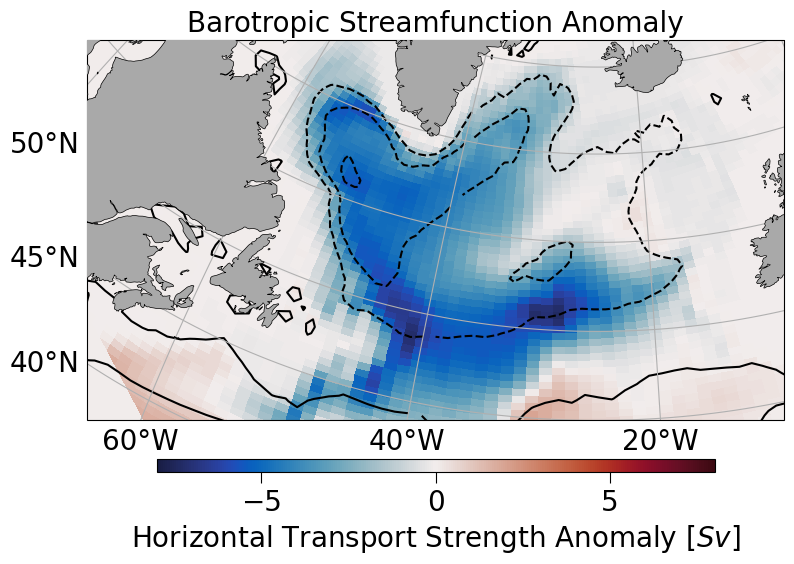

In [11]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Horizontal Transport Strength Anomaly [$Sv$]', 'pad': 0.05}

fig, ax = plt.subplots(figsize=(9, 10), subplot_kw={'projection': ccrs.Orthographic(central_latitude=50, central_longitude=-25)})
ax.set_extent([-70, -10, 45, 60], crs=ccrs.PlateCarree())

pc = ax.pcolormesh(ds_temp.ULONG, ds_temp.ULAT, anom_bsf_ds, 
                   transform=ccrs.PlateCarree(),
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

plt.contour(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0,40)).mean('time'), 
                   transform=ccrs.PlateCarree(), colors='k')
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray'), zorder=10)
ax.set_title('Barotropic Streamfunction Anomaly', fontsize=labelsize)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'bsf_anomaly.png', bbox_inches='tight', dpi=300, transparent=True)

### Density streamfunction

In [18]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

In [26]:
smoc_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/sMOC_anomaly.nc'
anom_smoc_ds = xr.open_dataset(smoc_file)

In [27]:
vmin = -12.5
vmax = -vmin

In [28]:
sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
#sigma_level = [32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 
#                            35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.3, 36.4, 36.46, 
#                            36.54, 36.6, 36.65, 36.69, 36.73, 36.75, 36.78, 36.82, 36.84, 36.86, 36.88, 36.9, 
#                            36.92, 36.94, 36.96, 36.98, 37.,]
fake_sigma = np.arange(len(sigma_level))

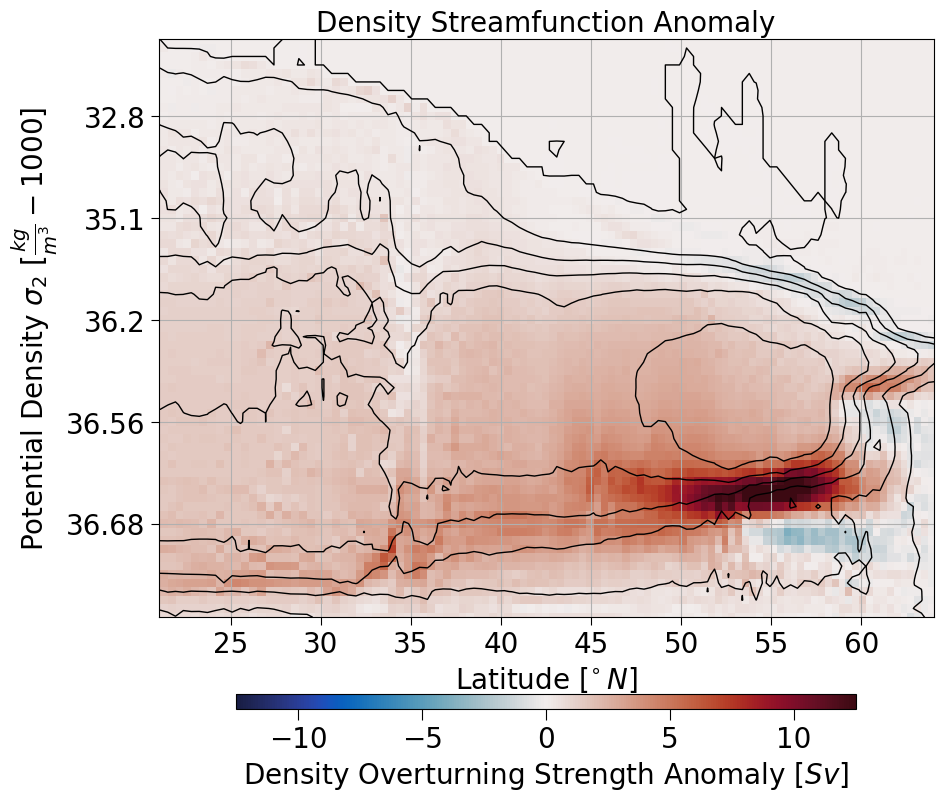

In [30]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, anom_smoc_ds.densMOC,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

plt.show()

#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Figure_2.png', bbox_inches='tight', dpi=300)

## Depth streamfunction

In [32]:
dmoc_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/dMOC_anomaly.nc'
anom_dmoc_ds = xr.open_dataarray(dmoc_file)

dmoc_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite.nc')

ps_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'

ds_ps = xr.open_dataset(ps_file).isel(time=0, nlon=0).squeeze()
replacement_value = 0

ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT'])

ds_ps['z_t'] = ds_ps.z_t *1e-2

In [33]:
vmin = -3
vmax = -vmin

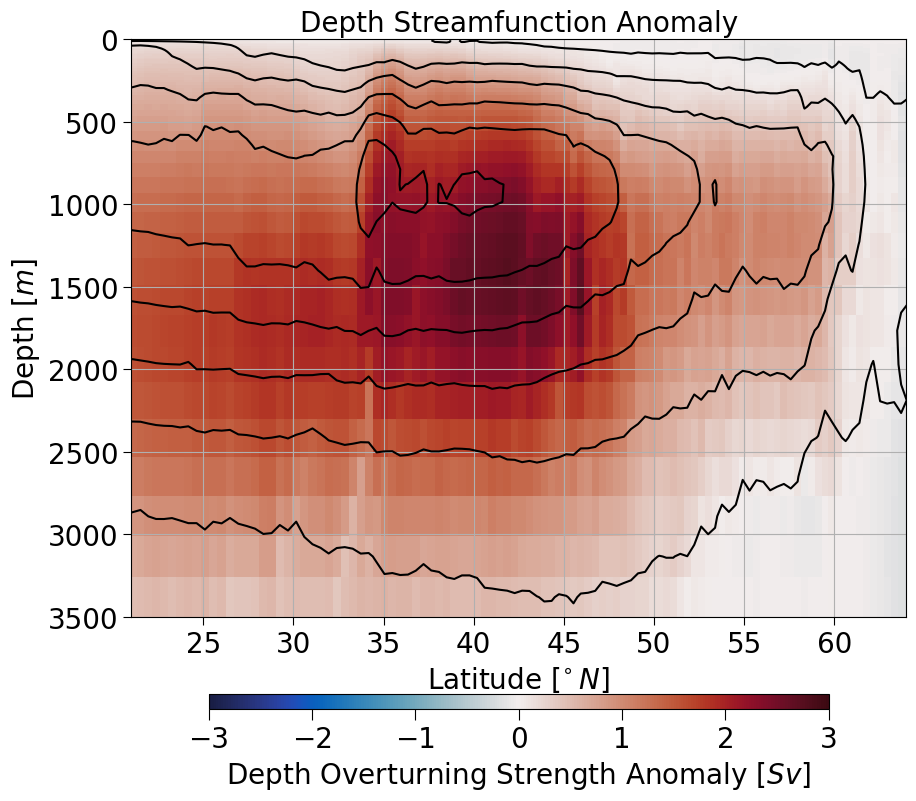

In [34]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Depth Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.ULAT, ds_ps.z_t, anom_dmoc_ds,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

plt.contour(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0,40)).mean('time'), colors='k')

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
ax.set_title('Depth Streamfunction Anomaly', fontsize=labelsize)


ax.invert_yaxis()
ax.set_xlim([21, 64]) 

ax.set_ylim([3500, 0]) 
plt.grid()


plt.ylabel(r'Depth [$m$]', fontsize = labelsize)
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize)

plt.show()

#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'dmoc_anomaly.png', bbox_inches='tight', dpi=300, transparent=True)

# Combined Plot

Font family: ['sans-serif']


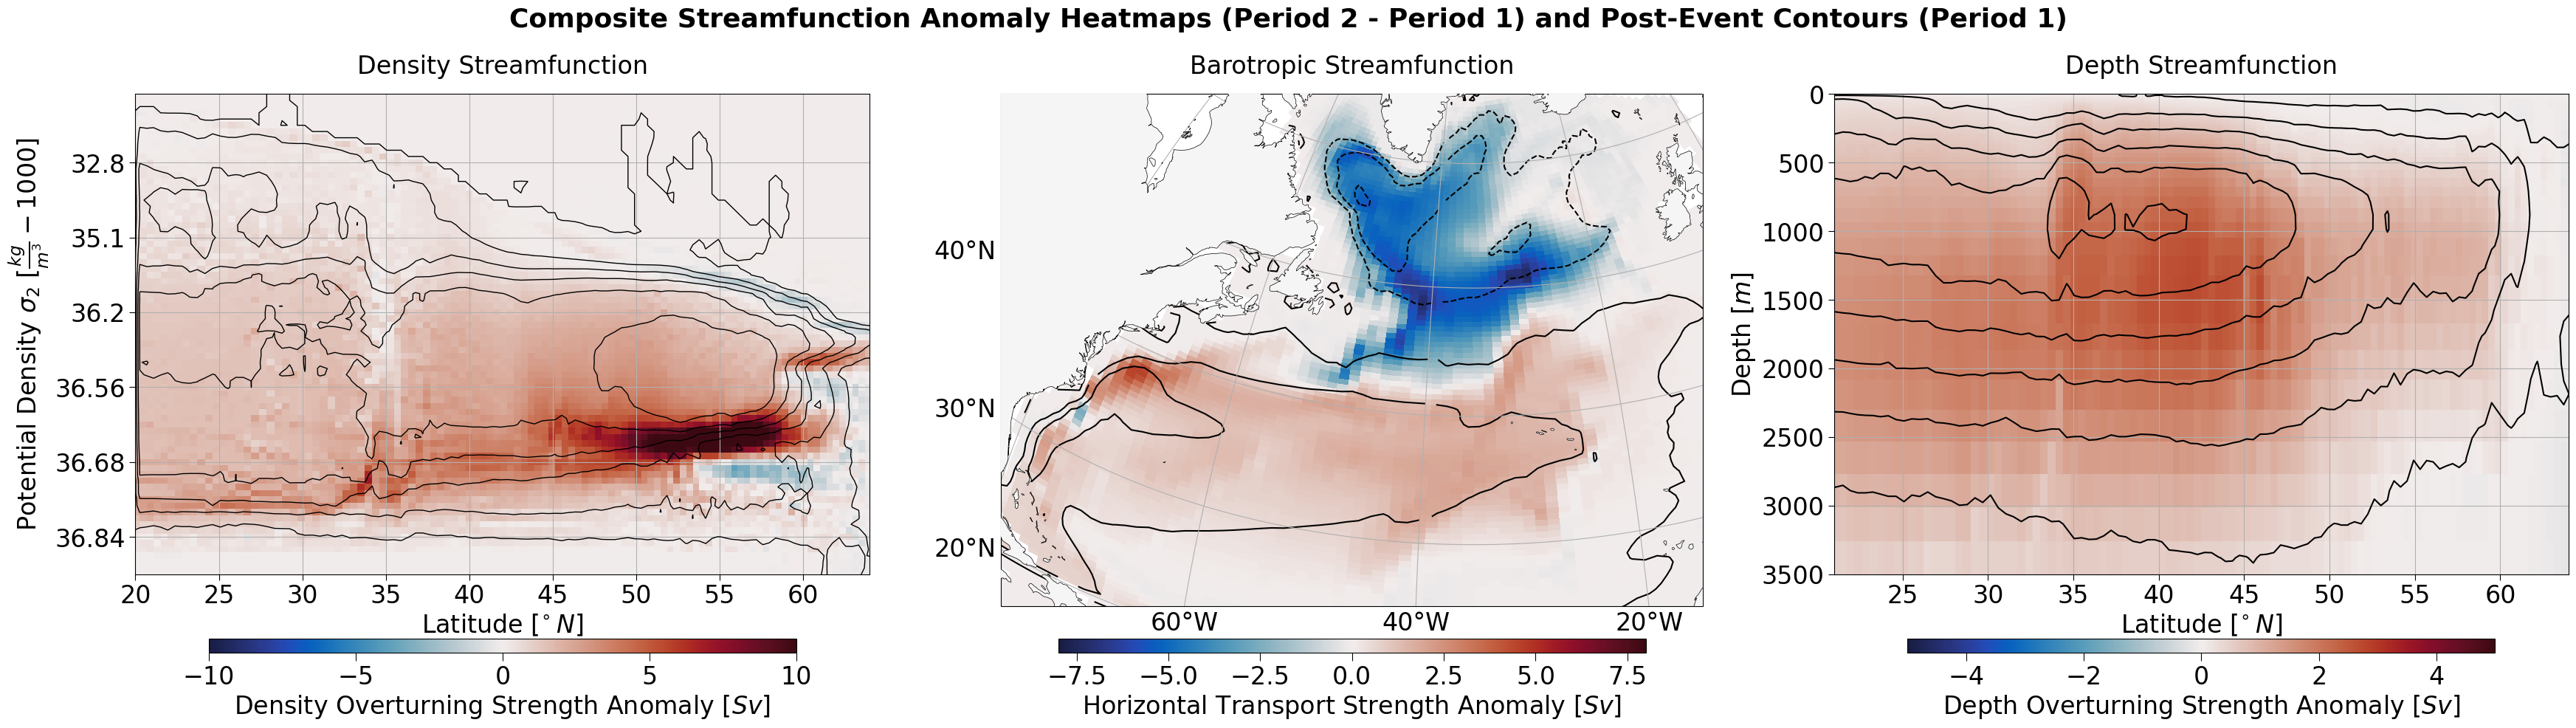

In [94]:
labelsize = 24

cbar_kwargs1 = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
                'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

cbar_kwargs2 = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
                'label': 'Horizontal Transport Strength Anomaly [$Sv$]', 'pad': 0.05}

cbar_kwargs3 = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
                'label': 'Depth Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

# Create the figure with three subplots in one row
fig = plt.figure(figsize=(35, 10))

# Plot 1: Density Streamfunction Anomaly
ax1 = plt.subplot(1, 3, 1)
ax1.set_position([0.05, 0.1, 0.25, 0.7])  # [left, bottom, width, height]
pc1 = ax1.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250, 365))), fake_sigma, anom_smoc_ds.densMOC,
                     cmap=cmo.balance, vmin=-10, vmax=10)
cbar1 = plt.colorbar(pc1, ax=ax1, **cbar_kwargs1)
cbar1.ax.xaxis.label.set_size(labelsize)
cbar1.ax.tick_params(axis='x', labelsize=labelsize, size=8)
ax1.contour(ds_ps.ULAT.isel(nlat=(slice(250, 365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0, 40)).mean('time'),
            linewidths=1, colors='k')
ax1.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
ax1.set_yticks(np.arange(len(sigma_level))[::12])
ax1.set_yticklabels(sigma_level[::12])
ax1.set_xlim([20, 64])
ax1.set_ylim([13, 90])
ax1.set_ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize=labelsize)
ax1.set_xlabel(r'Latitude [$^{\circ}\,N$]', fontsize=labelsize)
ax1.invert_yaxis()
ax1.grid()
ax1.set_title('Density Streamfunction', pad=20, fontsize=labelsize)

# Plot 2: Barotropic Streamfunction Anomaly
ax2 = plt.subplot(1, 3, 2, projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax2.set_position([0.35, 0.1, 0.4, 0.8])
ax2.set_extent([-80, -15, 25, 60], crs=ccrs.PlateCarree())
pc2 = ax2.pcolormesh(ds_temp.ULONG, ds_temp.ULAT, anom_bsf_ds,
                     transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-8, vmax=8, zorder=0)
cbar2 = plt.colorbar(pc2, ax=ax2, **cbar_kwargs2)
cbar2.ax.xaxis.label.set_size(labelsize)
cbar2.ax.tick_params(axis='x', labelsize=labelsize, size=8)
ax2.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
gl = ax2.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}
ax2.contour(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0, 40)).mean('time'),
            transform=ccrs.PlateCarree(), colors='k')
ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke'), zorder=10)
ax2.set_title('Barotropic Streamfunction', pad=20, fontsize=labelsize)

# Plot 3: Depth Streamfunction Anomaly
ax3 = plt.subplot(1, 3, 3)
ax3.set_position([0.8, 0.1, 0.2, 0.7])  # [left, bottom, width, height]
pc3 = ax3.pcolormesh(ds_ps.ULAT, ds_ps.z_t, anom_dmoc_ds,
                     cmap=cmo.balance, vmin=-5, vmax=5)
ax3.contour(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0, 40)).mean('time'), colors='k')
cbar3 = plt.colorbar(pc3, ax=ax3, **cbar_kwargs3)
cbar3.ax.xaxis.label.set_size(labelsize)
cbar3.ax.tick_params(axis='x', labelsize=labelsize, size=8)
ax3.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
ax3.invert_yaxis()
ax3.set_xlim([21, 64])
ax3.set_ylim([3500, 0])
ax3.set_ylabel(r'Depth [$m$]', fontsize=labelsize)
ax3.set_xlabel(r'Latitude [$^{\circ}\,N$]', fontsize=labelsize)
ax3.grid()
ax3.set_title('Depth Streamfunction', pad=20, fontsize=labelsize)

fig.suptitle('Composite Streamfunction Anomaly Heatmaps (Period 2 - Period 1) and Post-Event Contours (Period 1)', fontsize=26, fontweight='bold', x=0.5, y=1) # bottom-left (0, 0) and top-right (1, 1)

# Adjust layout
plt.tight_layout()
#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'sMOC_BSF_dMOC.png', bbox_inches='tight', dpi=300)

